In [1]:
import pandas as pd
import numpy as np
import torch 
from fredapi import Fred
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import mlflow
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import os
from torch import optim
import torch.nn as nn

In [2]:
batch_size = 4
seq_length = 2
random_seed = 1
torch.manual_seed(random_seed)
log_interval = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_folder = Path("./models")
print(device)

cuda:0


In [3]:
ml_client = MLClient.from_config(DefaultAzureCredential())

Found the config file in: C:\Users\armym\OneDrive\New folder (2)\Documents\ds\config.json


In [4]:
uri = ml_client.workspaces.get("workspace").mlflow_tracking_uri
mlflow.set_tracking_uri(uri)

In [5]:
%%writefile time_series_config.yaml
FRED:
    CPIAUCSL:
        name: CPI
        log: true
        diff: true
        diff_name: log_inflation_MoM
    FEDFUNDS:
        name: fed_rate
        log: true
        diff: true
    UNRATE:
        name: Unemployment
        log: false
        diff: false

Overwriting time_series_config.yaml


In [6]:
path = "./params"
os.makedirs(path, exist_ok=True)

In [7]:
def get_fred_api_key(path):
    with open(path, 'r') as f:
        key = f.read()
        return key

    
def get_data_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
        return config
        
config_path = Path("./configs")

key = get_fred_api_key(config_path / "fred_key.txt")
fred = Fred(api_key=key)

configs = get_data_config(config_path / "time_series_config.yaml")
fred_data = configs["FRED"]

def get_data(fred_data):
    data = {fred_data[code].get('name'): fred.get_series_latest_release(code) for code in fred_data}
    df = pd.DataFrame(data)
    return df

data = get_data(fred_data)
print(data.shape)
data.tail()

(926, 3)


,CPI,fed_rate,Unemployment
2023-10-01,307.531,5.33,3.8
2023-11-01,308.024,5.33,3.7
2023-12-01,308.742,5.33,3.7
2024-01-01,309.685,5.33,3.7
2024-02-01,311.054,5.33,3.9


In [8]:
def difference_data(df, config):
    for item in config:
        series = config[item]
        col = series['name']

        try:
            diff_name = series['diff_name'] 
        except Exception:
            diff_name = col + "_diff"
        
        if series['diff'] and series['log']:
            df[diff_name] =  np.log(df[col]).diff()
        elif series['diff']:
            df[diff_name] =  df[col].diff()

    return df.dropna()

data_diff = difference_data(data, fred_data)
print(data_diff.tail())

                CPI  fed_rate  Unemployment  log_inflation_MoM  fed_rate_diff  \
2023-10-01  307.531      5.33           3.8           0.000790            0.0   
2023-11-01  308.024      5.33           3.7           0.001602            0.0   
2023-12-01  308.742      5.33           3.7           0.002328            0.0   
2024-01-01  309.685      5.33           3.7           0.003050            0.0   
2024-02-01  311.054      5.33           3.9           0.004411            0.0   

            Unemployment_diff  
2023-10-01                0.0  
2023-11-01               -0.1  
2023-12-01                0.0  
2024-01-01                0.0  
2024-02-01                0.2  


<Axes: >

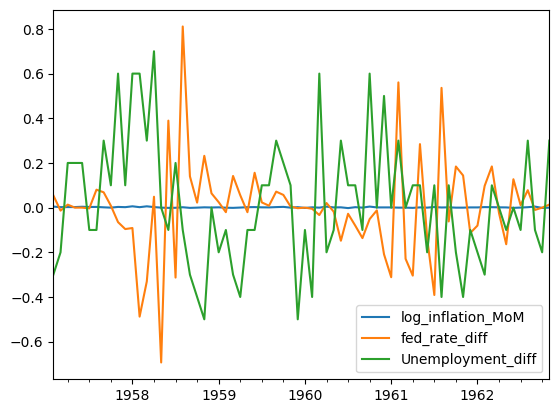

In [10]:
data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]].iloc[30:100].plot()

<Axes: >

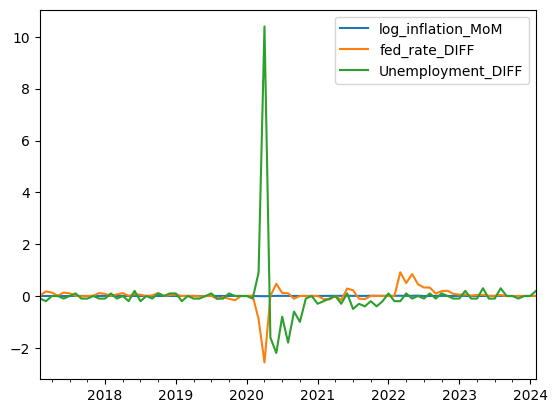

In [600]:
data_diff[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]].iloc[750:].plot()

In [605]:
data_diff.loc["2020-03-01"]

CPI                  258.150000
Unemployment           4.400000
fed_rate               0.650000
log_inflation_MoM     -0.004237
fed_rate_DIFF         -0.888208
Unemployment_DIFF      0.900000
Name: 2020-03-01 00:00:00, dtype: float64

In [26]:
cutoff = int(data_diff.shape[0]*0.80)
print(cutoff)
cutoff_date = str(data_diff.iloc[cutoff-1].name)
cutoff_date

668


'2010-03-01 00:00:00'

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

class MonetaryPolicyDataSet(torch.utils.data.Dataset):
    def __init__(self, train=True, train_end_year=None, seq_length=3):
        self.seq_length = seq_length
        
        configs = get_data_config(config_path / "time_series_config.yaml")
        self.data_dict = configs["FRED"]
        
        
        data = get_data(self.data_dict)
        self.data = difference_data(data, self.data_dict)[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]]
        self.data = self.data[self.data.index != "2020-04-01"]
        
        if train:
            self.data = self.data.loc[:train_end_year]
            scaler.fit(self.data)
        else:
            # Create test set after the train_end_year
            self.data = self.data.loc[pd.to_datetime(train_end_year) + pd.DateOffset(months=1):]
        
        self.data = scaler.transform(self.data)
        # Convert to pytorch tensor
        self.data = torch.tensor(self.data)
        
        
    def __getitem__(self, t):
        return self.data[t: t + self.seq_length], self.data[t + self.seq_length]
    
    
    def __len__(self):
        return len(self.data) - self.seq_length

In [152]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_data_loaders(train_cutoff, seq_length):

    train_dataset = MonetaryPolicyDataSet(train=True, train_end_year=train_cutoff, seq_length = seq_length)
    test_dataset = MonetaryPolicyDataSet(train=False, train_end_year=train_cutoff, seq_length = seq_length)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_dataloader, test_dataloader 

train_dataloader, test_dataloader = get_data_loaders("2010-03-01", seq_length)

batch_id, (x, y) = next(enumerate(train_dataloader))
print(x, y)
print(x.size())

tensor([[[-1.1033,  3.7324,  1.0097],
         [-1.4557, -1.1326,  0.4889]],

        [[-1.4557, -1.1326,  0.4889],
         [-2.0453, -2.0031, -2.1153]],

        [[-2.0453, -2.0031, -2.1153],
         [-0.2794, -0.1882, -2.1153]],

        [[-0.2794, -0.1882, -2.1153],
         [-1.1037,  3.8309, -1.5945]]], dtype=torch.float64) tensor([[-2.0453, -2.0031, -2.1153],
        [-0.2794, -0.1882, -2.1153],
        [-1.1037,  3.8309, -1.5945],
        [-0.9860,  0.7462, -0.5528]], dtype=torch.float64)
torch.Size([4, 2, 3])


In [16]:
batch_id, (x, y) = next(enumerate(test_dataloader))
print(x)

tensor([[[-0.9136,  1.9836, -0.0320],
         [-1.1498,  0.0212, -1.5945]],

        [[-1.1498,  0.0212, -1.5945],
         [-1.1180, -0.9054, -1.0736]],

        [[-1.1180, -0.9054, -1.0736],
         [-0.3977,  0.0212, -0.0320]],

        [[-0.3977,  0.0212, -0.0320],
         [-0.5260,  0.4967,  0.4889]]], dtype=torch.float64)


In [17]:
import torch.functional as F
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        
        self.recurrent_layer = torch.nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first = True,
            bidirectional = False
        )
        
        self.fc1 = torch.nn.Linear(hidden_size, 3, bias=True)        
        
    def forward(self, x):
        x, hidden = self.recurrent_layer(x)
        x = self.fc1(x[:,-1, :])
        
        return x        

## Test forward

In [18]:
scaled_data = scaler.transform(data_diff[["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"]])
scaled_data_df = pd.DataFrame(scaled_data, columns = ["log_inflation_MoM", "fed_rate_diff", "Unemployment_diff"])
scaled_data_df = scaled_data_df[scaled_data_df != "2020-04-01"]
scaled_data_df.head()

,log_inflation_MoM,fed_rate_diff,Unemployment_diff
0,-1.103319,3.732441,1.009706
1,-1.455662,-1.132588,0.488869
2,-2.045286,-2.003120,-2.115314
3,-0.279442,-0.188215,-2.115314
4,-1.103669,3.830898,-1.594478


In [19]:
# Test forward pass
model = RNNModel(3, 20)
torch.manual_seed(1)
test_input = x.float()
print("Input:")
print(test_input.float())
print(test_input.shape)
with torch.no_grad():
    print("Output: ")
    out = model(test_input)
    print(out)
    print("true values:", y.float())

Input:
tensor([[[-0.9136,  1.9836, -0.0320],
         [-1.1498,  0.0212, -1.5945]],

        [[-1.1498,  0.0212, -1.5945],
         [-1.1180, -0.9054, -1.0736]],

        [[-1.1180, -0.9054, -1.0736],
         [-0.3977,  0.0212, -0.0320]],

        [[-0.3977,  0.0212, -0.0320],
         [-0.5260,  0.4967,  0.4889]]])
torch.Size([4, 2, 3])
Output: 
tensor([[-0.4362, -0.3871,  0.0495],
        [-0.2418, -0.2462,  0.1447],
        [-0.1036, -0.2096,  0.1702],
        [-0.1596, -0.2529,  0.1542]])
true values: tensor([[-1.1180, -0.9054, -1.0736],
        [-0.3977,  0.0212, -0.0320],
        [-0.5260,  0.4967,  0.4889],
        [-0.4776,  0.0212, -0.0320]])


In [20]:
mse = nn.MSELoss()
mse(model(test_input), y)

tensor(0.2593, dtype=torch.float64, grad_fn=<MseLossBackward0>)

## Train RNN

In [128]:
from torch import optim
import torch.nn as nn

class RNN:
    def __init__(self, rnn, model_name, n_epoch:int, 
                 train_loader, validation_loader, 
                 learning_rate:float=0.0001, gradient_clipping=None,
                 device = None, train_data_end_date = None,
                ):
        self.n_epoch, self.lr, self.graident_clip = n_epoch, learning_rate, gradient_clipping

        self.train_loader, self.validation_loader = train_loader, validation_loader
        
        self.net = rnn
        self.model_name = model_name
        
        self.optimizer = optim.Adam(
                lr=self.lr, 
                params=self.net.parameters()
            ) 
        
        # Mean squared error loss
        self.loss = nn.MSELoss()

        self.best_validation_loss = 1000000
        self.best_model = None
        self.device = device
        
        self.train_data_end_date = train_data_end_date

        
    def train(self):
        with mlflow.start_run() as run:
            self.run = run
            self.log_params()
            
            self.train_error = []
            self.val_error = []
            for epoch in range(1, self.n_epoch + 1):
                self.train_loop(epoch)
                self.validation(epoch)
            self.log_loss()
            self.log_model(self.best_validation_loss)
            mlflow.log_metric("Best-validation-loss", self.best_validation_loss)

        
    def train_loop(self, epoch):
        losses = []
        self.net.train()
        for idx, (x, y) in enumerate(self.train_loader):
            
            x = x.to(self.device).float()
            y = y.to(self.device).float()

            # Calculate losses and optimize 
            self.optimizer.zero_grad()
            output = self.net(x)
            loss = self.loss(output, y)
            losses.append(loss.item())
            loss.backward()

            if self.graident_clip:
                nn.utils.clip_grad_norm_(self.net.parameters(), self.graident_clip)

            self.optimizer.step()

            if idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(x), len(self.train_loader.dataset),
                100. * idx / len(self.train_loader), loss.item()))
                
        
        # if epoch % 10 == 0:
        #     with torch.no_grad():
        #         for i, param in enumerate(self.net.parameters()):
        #             p = param.cpu().numpy()
        #             df = pd.DataFrame(p)
        #             df.to_csv(f"./params/params_{i}.csv")
        #         mlflow.log_artifacts("./params", f"./params/{epoch}")
        
        avg_loss = np.mean(losses)
        self.train_error.append(avg_loss)
        print("Epoch {} average train loss: {:.6f}".format(epoch, avg_loss))

    
    def validation(self, epoch):
        losses = []
        for idx, (x, y) in enumerate(self.validation_loader):
            x = x.to(self.device).float()
            y = y.to(self.device).float()
            
            self.net.eval()
            with torch.no_grad():
                validation_output = self.net(x)#.reshape(-1,3)
                loss_val = self.loss(validation_output, y)
                losses.append(loss_val.item())
                
        avg_loss = np.mean(losses)

        # Track the best model and validation loss
        if avg_loss < self.best_validation_loss:
            self.best_validation_loss = avg_loss
            torch.save(self.net, model_folder / f"{self.model_name}.pt")
            

        self.val_error.append(avg_loss)
        print("Epoch {} average validation loss: {:.6f}".format(epoch, avg_loss))
    
    
    def log_params(self):
        mlflow.log_params(
            {
                "batch size": batch_size,
                "epochs": self.n_epoch,
                "sequence length": seq_length,
                "learning_rate": self.lr,
                "hidden size": self.net.hidden_size,
                "optimizer": self.optimizer,
                "gradient clipping": self.graident_clip

            }
        )

        # Log  data size
        mlflow.log_param("Train data end", self.train_data_end_date)
        mlflow.log_param("Train data size", len(train_dataloader.dataset))
        mlflow.log_param("Validation data size", len(test_dataloader.dataset))


    def log_model(self, loss):
        print("Saving best model with lowest validation mse loss = {}".format(loss))        
        best_model = torch.load(model_folder / f"{self.model_name}.pt")
        best_model.eval()
        mlflow.pytorch.log_model(best_model, "best_model")


    def log_loss(self):
        log_every = 10
        for epoch, val in enumerate(self.train_error):
            if epoch % log_every == 0:
                mlflow.log_metric(f"train mean loss", val, step=epoch)
            
        for epoch, val in enumerate(self.val_error):
            if epoch % log_every == 0:
                mlflow.log_metric(f"val-loss", val, step=epoch)

    
    def predict(self, x):
        with torch.no_grad():
            return self.net(x.to(self.device).float())
            
            
    def load_model(self, path):
        self.net = torch.load(path)

In [28]:
# Set the training experiment
mlflow.set_experiment('MonetaryPolicyRNN')
hidden_size = 16

# Initialize model
model = RNNModel(3, hidden_size).to(device)
rnn = RNN(model, "RNN", 120, train_dataloader, test_dataloader, 
          learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)
# Train
rnn.train()

Train Epoch: 1 [0/666 (0%)]	Loss: 2.773067
Train Epoch: 1 [400/666 (60%)]	Loss: 0.414855
Epoch 1 average train loss: 0.992421
Epoch 1 average validation loss: 2.013375
Train Epoch: 2 [0/666 (0%)]	Loss: 2.686324
Train Epoch: 2 [400/666 (60%)]	Loss: 0.409962
Epoch 2 average train loss: 0.968969
Epoch 2 average validation loss: 1.994711
Train Epoch: 3 [0/666 (0%)]	Loss: 2.623343
Train Epoch: 3 [400/666 (60%)]	Loss: 0.407912
Epoch 3 average train loss: 0.949943
Epoch 3 average validation loss: 1.980315
Train Epoch: 4 [0/666 (0%)]	Loss: 2.570452
Train Epoch: 4 [400/666 (60%)]	Loss: 0.407638
Epoch 4 average train loss: 0.933843
Epoch 4 average validation loss: 1.969076
Train Epoch: 5 [0/666 (0%)]	Loss: 2.525362
Train Epoch: 5 [400/666 (60%)]	Loss: 0.408570
Epoch 5 average train loss: 0.920021
Epoch 5 average validation loss: 1.960253
Train Epoch: 6 [0/666 (0%)]	Loss: 2.486406
Train Epoch: 6 [400/666 (60%)]	Loss: 0.410328
Epoch 6 average train loss: 0.908023
Epoch 6 average validation loss: 1

2024/03/22 15:43:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saving best model with lowest validation mse loss = 1.9241340298478196


2024/03/22 15:43:47 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.10.0, required: mlflow==2.11.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


### Note that the validation error will probably be way larger due to the covid shock

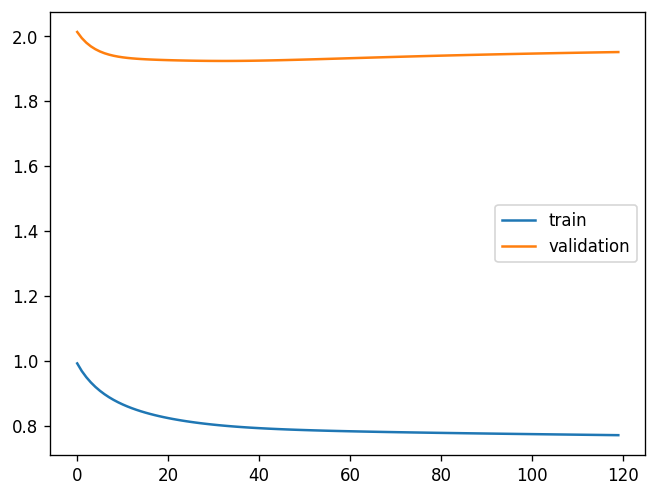

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)

ax.plot(np.arange(len(rnn.train_error)), rnn.train_error, label='train')
ax.plot(np.arange(len(rnn.val_error)), rnn.val_error, label='validation')
plt.legend()

## Look at some of the fitted values

In [30]:
means = scaler.mean_
standard_devs = np.sqrt(scaler.var_)

In [39]:
rnn.load_model("./models/RNN.pt")

In [40]:
def get_predictions(model, loader, return_residuals = False):
    mse = nn.MSELoss(reduction="none")
    predictions = []
    residuals = []
    for idx, (x, y) in enumerate(loader):
        pred = model.predict(x)
        predictions.append(pred)
        
        res = pred-y.to(device)
        residuals.append(res)
        
    predictions_concat = torch.concat(predictions, dim=0).cpu().numpy()
    residuals_concat = torch.concat(residuals, dim=0).cpu().numpy()
    if return_residuals:
        return predictions_concat, residuals_concat
    else:
        return predictions_concat

In [41]:

def plot_predictions(model, range_:list, loader, test=False):
    predictions = get_predictions(model, loader)

    # If we are testing we need to start the index at the cutoff for when we concatinate predictions 
    # with the actual values
    predictions_index = None if not test else np.arange(cutoff+seq_length+1, scaled_data_df.shape[0])
    
    predictions_df = pd.DataFrame(
        predictions, 
        columns = ["log_inflation_MoM_pred", "fed_rate_diff_pred", "Unemployment_diff_pred"], 
        index=predictions_index
    )

    fig, axs = plt.subplots(3, dpi=120, figsize=(14, 10))
    all_data = pd.concat([scaled_data_df, predictions_df], ignore_index=False, axis=1)


    (all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]]*standard_devs[0] + means[0]).iloc[range_[0]:range_[1]].plot(ax=axs[0])
    (all_data[["fed_rate_diff_pred", "fed_rate_diff"]]*standard_devs[1] + means[1]).iloc[range_[0]:range_[1]].plot(ax=axs[1])
    (all_data[["Unemployment_diff_pred", "Unemployment_diff"]]*standard_devs[2] + means[2]).iloc[range_[0]:range_[1]].plot(ax=axs[2])

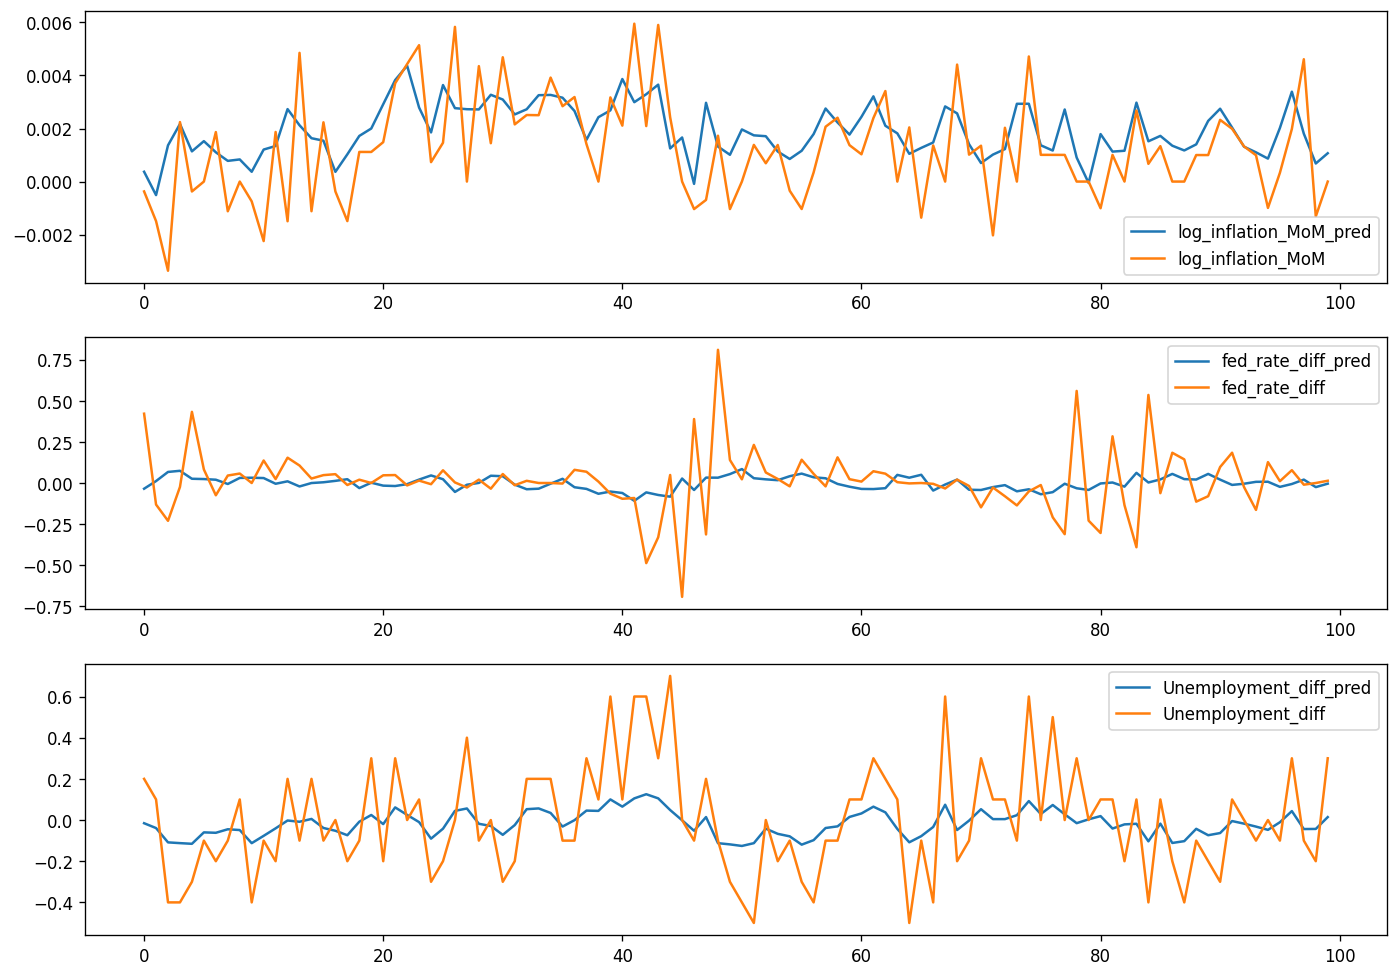

In [42]:
plot_predictions(rnn, [0, 100], train_dataloader)

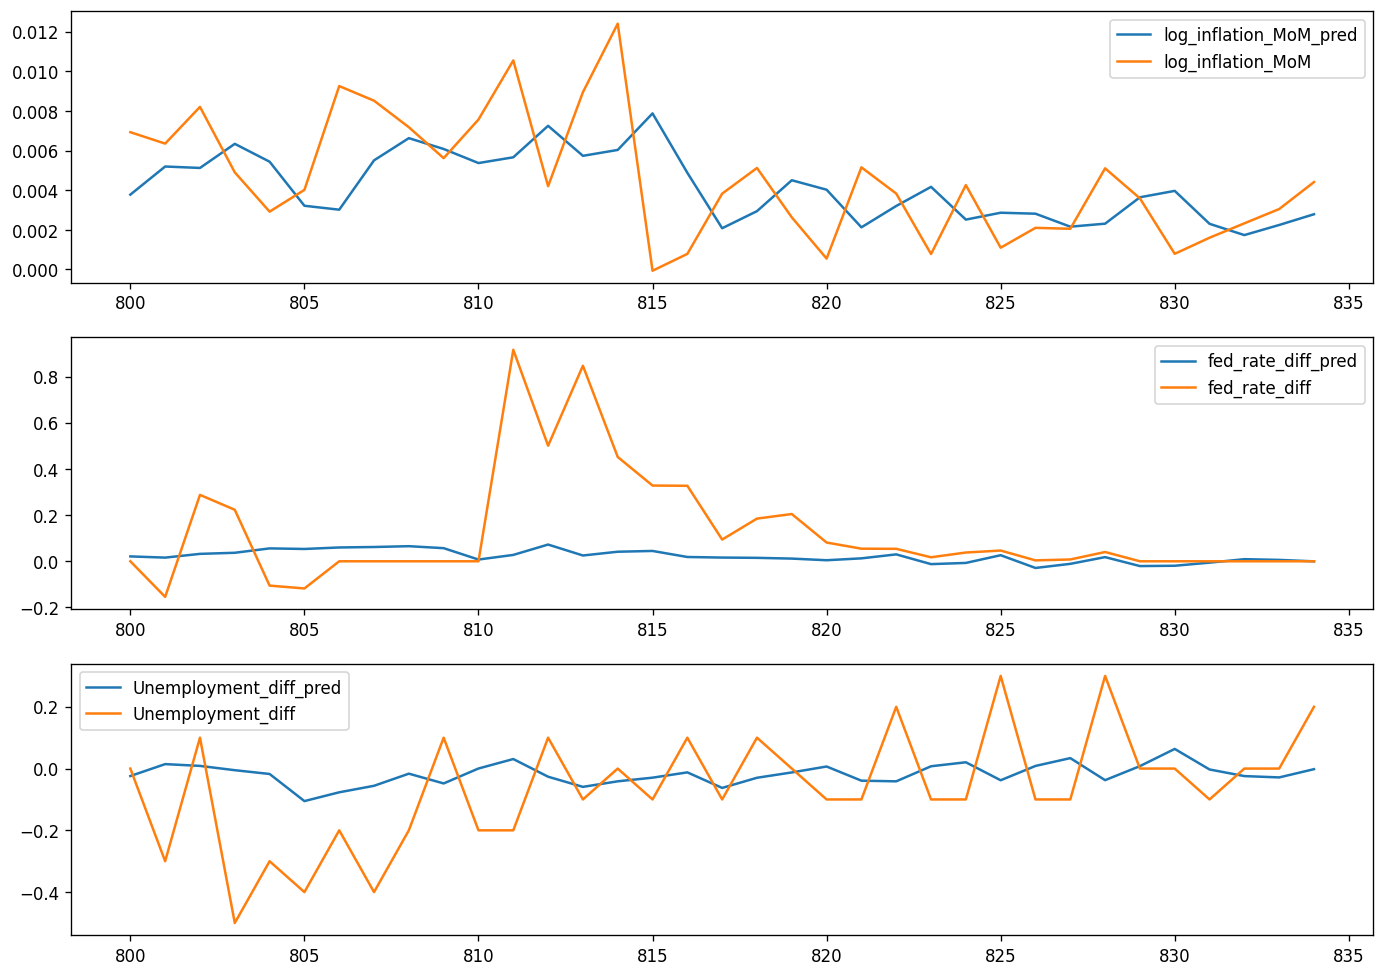

In [37]:
plot_predictions(rnn, [800, data_diff.shape[0]], test_dataloader, test=True)

## Check that residuals are white noise

Text(0.5, 1.0, 'Unemployment_DIFF_pred Residuals')

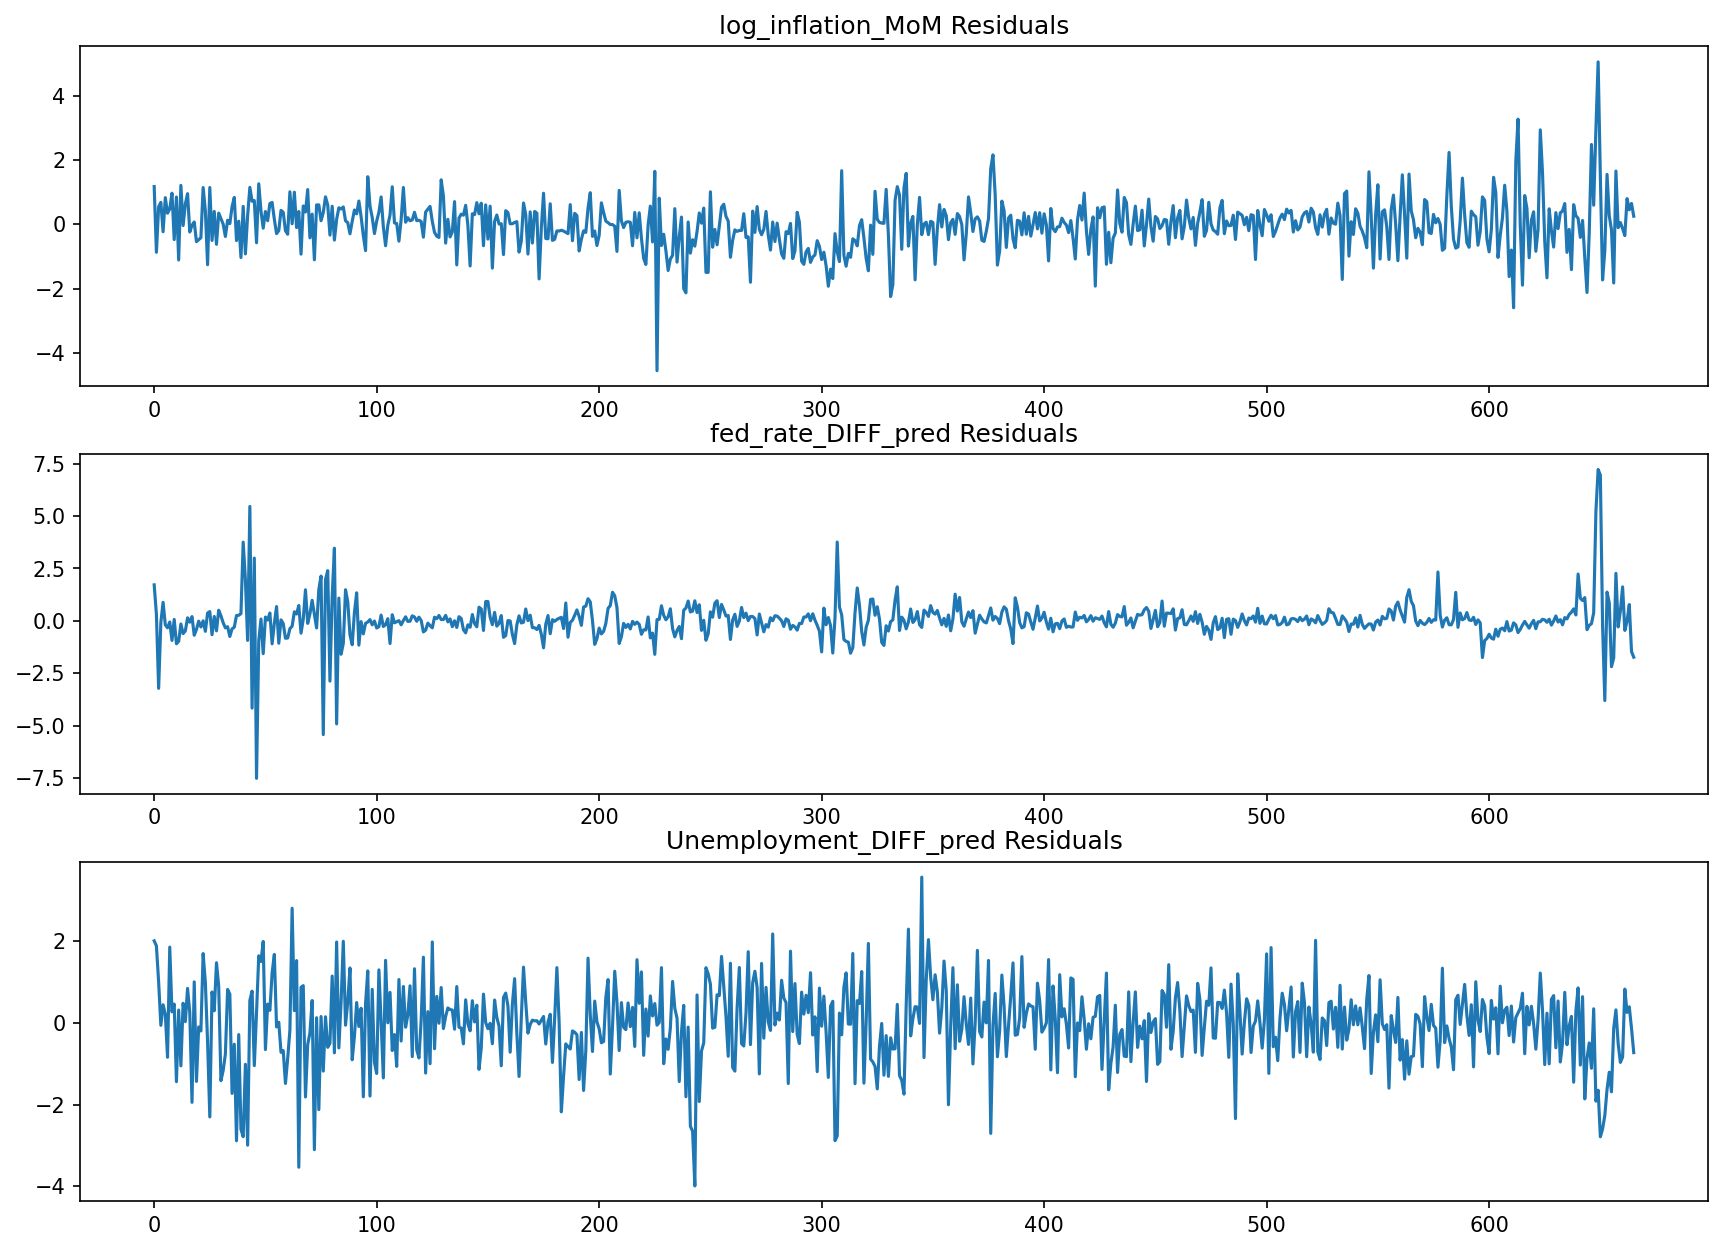

In [43]:
pred, res = get_predictions(rnn, train_dataloader,return_residuals=True)
residuals_df = pd.DataFrame(
        res, 
        columns = ["log_inflation_MoM_pred_res", "fed_rate_DIFF_pred_res", "Unemployment_DIFF_pred_res"]
    )

fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))

residuals_df["log_inflation_MoM_pred_res"].plot(ax=axs[0])
residuals_df["fed_rate_DIFF_pred_res"].plot(ax=axs[1])
residuals_df["Unemployment_DIFF_pred_res"].plot(ax=axs[2])
axs[0].set_title("log_inflation_MoM Residuals")
axs[1].set_title("fed_rate_DIFF_pred Residuals")
axs[2].set_title("Unemployment_DIFF_pred Residuals")

----

# LSTM With Pytorch

----

## Input gate, output gate, and forget gate
$I = \sigma(\mathbf{X}_t\mathbf{W}_{xi} + \mathbf{H}_{t-1}\mathbf{W}_{hi} + \mathbf{b}_{i}) \\ $ 
$O = \sigma(\mathbf{X}_t\mathbf{W}_{xo} + \mathbf{H}_{t-1}\mathbf{W}_{ho} + \mathbf{b}_{o}) \\ $
$F = \sigma(\mathbf{X}_t\mathbf{W}_{xf} + \mathbf{H}_{t-1}\mathbf{W}_{hf} + \mathbf{b}_{f})$

In [374]:
class Gate(nn.Module):
    def __init__(self, input_size, hidden_size, activation = "sigmoid"):
        super(Gate, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Params for input gate
        self.W_xi = nn.Parameter(
            torch.randn(input_size, hidden_size),
        )
        
        self.W_hi = nn.Parameter(
            torch.randn(hidden_size, hidden_size),
        )
         
        self.b_i = nn.Parameter(
            torch.zeros(hidden_size),     
        )
        
        
        self.activation = nn.Tanh() if activation == "tanh" else nn.Sigmoid()

        self.initialize_params()


    def initialize_params(self):
        a = np.sqrt(1/self.hidden_size)
        for param in self.parameters():
            param.data.uniform_(-a, a)
        
    
    def forward(self, X, old_state = None):
        if old_state is None:
            # Initiallize hidden state
            old_state = torch.zeros((X.shape[0], self.hidden_size),
                          device=X.device)   

        return self.activation(torch.matmul(X, self.W_xi) + 
                              torch.matmul(old_state, self.W_hi) + self.b_i) 

In [375]:
# Test the input gate forward pass
I = Gate(3, 5).to(device)
with torch.no_grad():
    print(x[0].shape)
    print(I(x[0].to(device).float()))

torch.Size([2, 3])
tensor([[0.3752, 0.4349, 0.2190, 0.7001, 0.2893],
        [0.5894, 0.6637, 0.4283, 0.4344, 0.7067],
        [0.3719, 0.8129, 0.2731, 0.3470, 0.8672],
        [0.2816, 0.6610, 0.3173, 0.5466, 0.6631]], device='cuda:0')


In [379]:
class MemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MemoryCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.I = Gate(self.input_size, self.hidden_size)
        self.F = Gate(self.input_size, self.hidden_size)
        self.O = Gate(self.input_size, self.hidden_size)
        
        self.input_node = Gate(self.input_size, self.hidden_size, activation='tanh')
        
        self.tanh = nn.Tanh()
    
    
    def forward(self, X, state = None, internal_state = None):
        if state is None:
            state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)    
        if internal_state is None:
            internal_state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)  
            
        outputs = []
        for x in X:
            I = self.I(x, state)
            F = self.F(x, state)
            O = self.O(x, state)
            input_ = self.input_node(x, state)
            internal_state = F * internal_state + I * input_
            state = O * torch.tanh(internal_state)
            outputs.append(state)
            
        try:
            h = torch.stack(outputs, 0)
        except Exception as e:
            print(e)
            print("shape:", X.shape)
            print("outputs:", outputs)
        else:
            return h, (state, internal_state)

In [380]:
# Test forward
torch.manual_seed(1)
memory = MemoryCell(3, 5).to(device)
with torch.no_grad():
    o, _ = memory(x.to(device).float())
    print(o)

tensor([[[ 0.0007,  0.2468, -0.0260, -0.0419,  0.0451],
         [-0.0113,  0.1095, -0.1877,  0.1340, -0.0524]],

        [[ 0.0192,  0.3065, -0.2201,  0.0744, -0.0367],
         [ 0.0341,  0.1204, -0.1540,  0.1927, -0.0374]],

        [[ 0.1163,  0.2010, -0.1569,  0.1595, -0.0324],
         [-0.0443,  0.0830, -0.0897,  0.1408, -0.0839]],

        [[ 0.0101,  0.0929, -0.0843,  0.1190, -0.0713],
         [-0.0101,  0.2719, -0.0304, -0.0386, -0.1528]]], device='cuda:0')


In [381]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.memory = MemoryCell(input_size, hidden_size)
        
        self.fc1 = nn.Linear(hidden_size, 3)
    
    def forward(self, X):
        x, (h, c) = self.memory(X)
        return self.fc1(x[:, -1, :])
        

In [382]:
# Test forward
lstm = LSTM(3, 20)
with torch.no_grad():
    o = lstm(x.float())
    print(o)

tensor([[-0.1857,  0.0585, -0.2485],
        [-0.1694,  0.1131, -0.2945],
        [-0.1757,  0.1343, -0.2867],
        [-0.1300,  0.1232, -0.3284]])


### Train LSTM

In [383]:
hidden_size = 16
seq_length = 2
train_dataloader, test_dataloader = get_data_loaders(cutoff_date, seq_length)

lstm = LSTM(3, hidden_size).to(device)
lstm_model = RNN(lstm, "LSTM", 120, train_dataloader, test_dataloader, 
                 learning_rate=0.0001, device=device, train_data_end_date=cutoff_date)

mlflow.set_experiment('LSTM_training')
# Train LSTM
lstm_model.train()

Train Epoch: 1 [0/666 (0%)]	Loss: 3.201854
Train Epoch: 1 [400/666 (60%)]	Loss: 0.429046
Epoch 1 average train loss: 1.027730
Epoch 1 average validation loss: 2.148792
Train Epoch: 2 [0/666 (0%)]	Loss: 3.177698
Train Epoch: 2 [400/666 (60%)]	Loss: 0.428703
Epoch 2 average train loss: 1.019796
Epoch 2 average validation loss: 2.143624
Train Epoch: 3 [0/666 (0%)]	Loss: 3.158869
Train Epoch: 3 [400/666 (60%)]	Loss: 0.428520
Epoch 3 average train loss: 1.012379
Epoch 3 average validation loss: 2.138725
Train Epoch: 4 [0/666 (0%)]	Loss: 3.140445
Train Epoch: 4 [400/666 (60%)]	Loss: 0.428456
Epoch 4 average train loss: 1.005225
Epoch 4 average validation loss: 2.134033
Train Epoch: 5 [0/666 (0%)]	Loss: 3.122372
Train Epoch: 5 [400/666 (60%)]	Loss: 0.428496
Epoch 5 average train loss: 0.998291
Epoch 5 average validation loss: 2.129499
Train Epoch: 6 [0/666 (0%)]	Loss: 3.104558
Train Epoch: 6 [400/666 (60%)]	Loss: 0.428631
Epoch 6 average train loss: 0.991536
Epoch 6 average validation loss: 2

2024/03/22 21:10:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saving best model with lowest validation mse loss = 1.9934799911045447


2024/03/22 21:10:30 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.10.0, required: mlflow==2.11.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [391]:
# Get experiments sorted by best validations score
client = mlflow.MlflowClient() 
exp = mlflow.get_experiment_by_name('LSTM_training')
runs = mlflow.search_runs(exp.experiment_id)
runs = runs[runs['status'] != "FAILED"]
runs.sort_values(by="metrics.Best validation loss").head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train mean loss,metrics.val loss,metrics.Best validation loss,metrics.val-loss,...,params.optimizer,params.hidden size,params.sequence length,params.gradient clipping,params.Train data end,params.Train data size,params.Validation data size,tags.mlflow.user,tags.mlflow.rootRunId,tags.mlflow.runName
18,96335e53-d488-421d-8c0b-5c2a48053f80,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-22 21:47:59.765000+00:00,2024-03-22 21:51:58.249000+00:00,0.773501,1.980380,1.979774,NaN,...,Adam (\nParameter Group 0\n amsgrad: False\...,16,2,1,2010-03-01 00:00:00,666,164,Garett Kaube,96335e53-d488-421d-8c0b-5c2a48053f80,willing_circle_f8ryf8rr
17,d31f2e84-615f-4dd9-baa0-64b3fc61000e,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-22 00:43:19.152000+00:00,2024-03-22 00:46:51.011000+00:00,0.509793,2.972246,2.941829,NaN,...,Adam (\nParameter Group 0\n amsgrad: False\...,32,100,None,None,None,None,Garett Kaube,d31f2e84-615f-4dd9-baa0-64b3fc61000e,sincere_town_47zxrs2y
2,906e2f9e-50a0-4316-be47-a6167870e83b,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-21 13:56:05.819000+00:00,2024-03-21 14:01:04.113000+00:00,0.755244,2.408690,NaN,NaN,...,Adam (\nParameter Group 0\n amsgrad: False\...,16,2,None,None,None,None,Garett Kaube,906e2f9e-50a0-4316-be47-a6167870e83b,busy_deer_cqs39k28
3,f61909b7-5b93-4fd3-9299-1eb9bdc918c4,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-21 14:13:15.267000+00:00,2024-03-21 14:18:07.329000+00:00,0.792586,2.553793,NaN,NaN,...,Adam (\nParameter Group 0\n amsgrad: False\...,16,2,None,None,None,None,Garett Kaube,f61909b7-5b93-4fd3-9299-1eb9bdc918c4,jovial_cord_3j5z6qm8
4,7e8e4bac-3d42-423a-9cc4-aa370bfa70d9,536bf77d-2a14-4df7-9772-a61c8dfa01e7,FINISHED,,2024-03-21 14:21:21.750000+00:00,2024-03-21 14:28:03.638000+00:00,0.705775,2.533694,NaN,NaN,...,Adam (\nParameter Group 0\n amsgrad: False\...,16,2,None,None,None,None,Garett Kaube,7e8e4bac-3d42-423a-9cc4-aa370bfa70d9,silly_yuca_2q6c7hcm


In [388]:
# Load saved best model
lstm_model.load_model("./models/LSTM.pt")

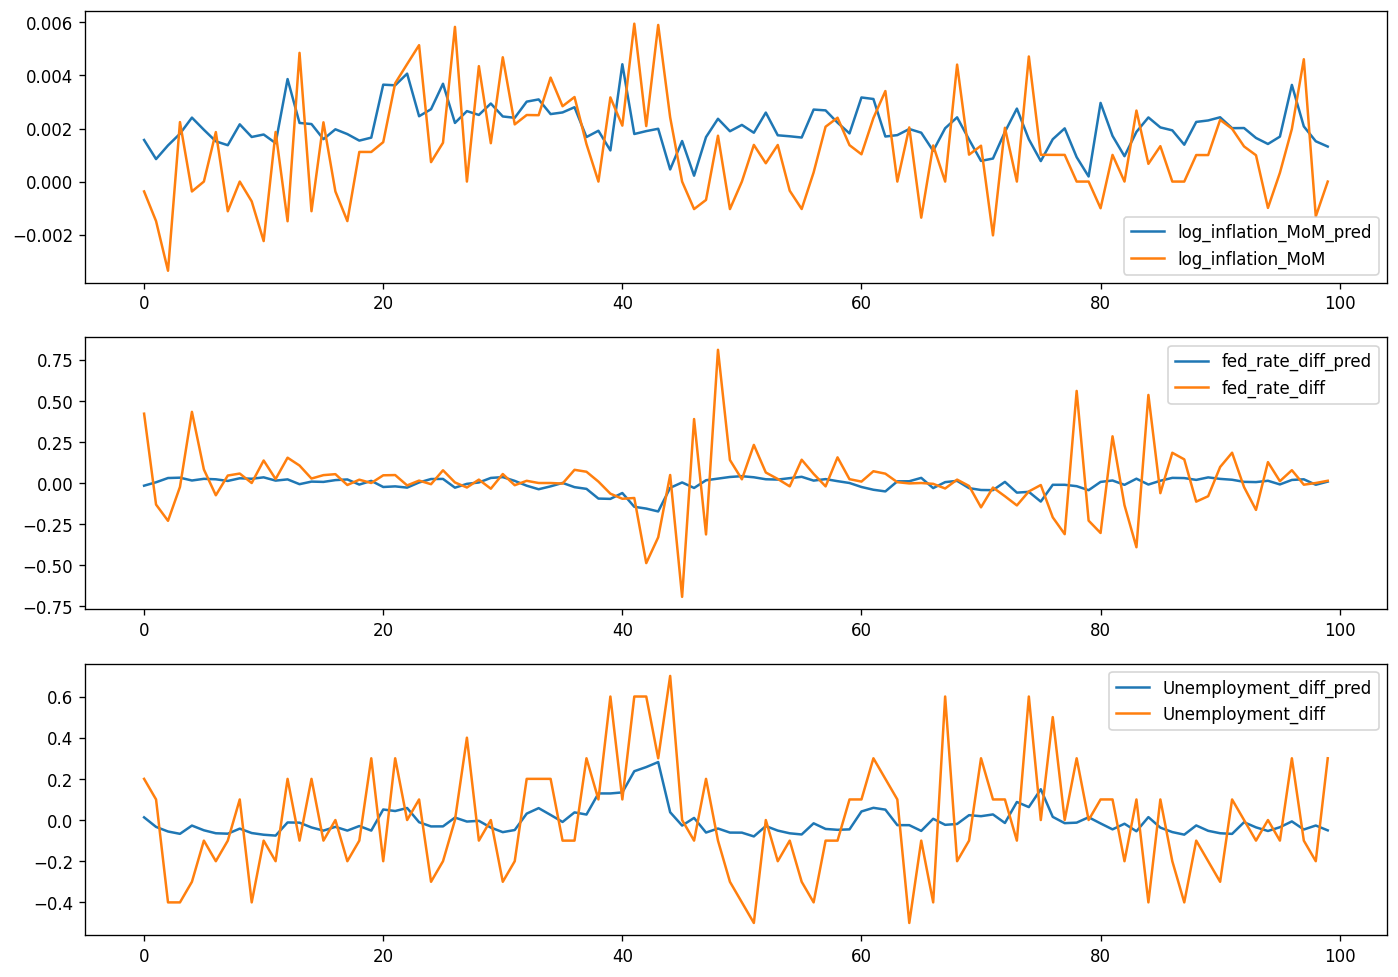

In [389]:
plot_predictions(lstm_model, [0, 100], train_dataloader)

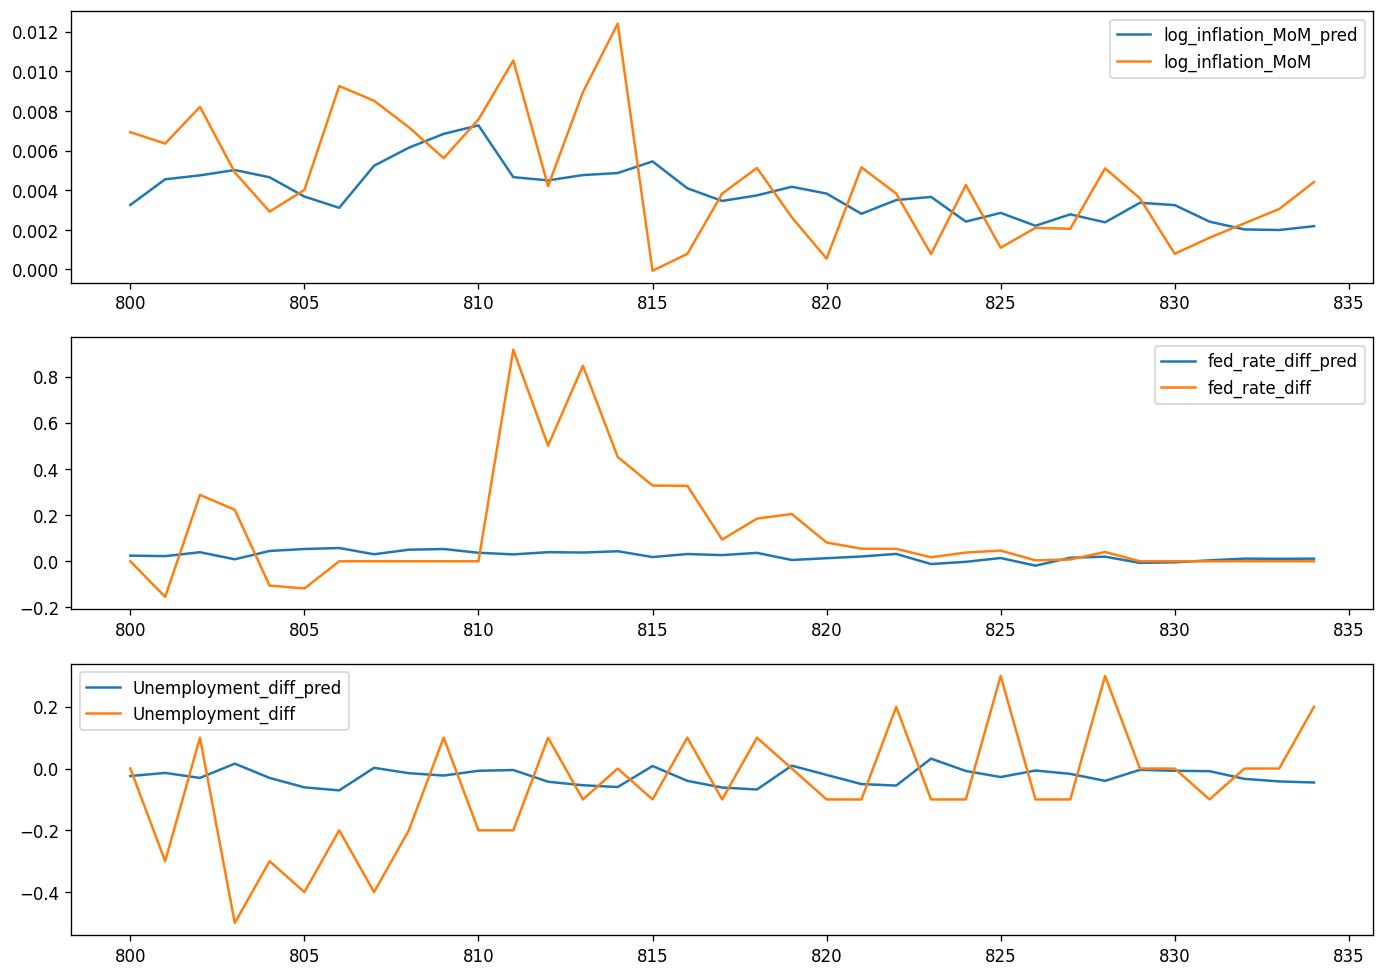

In [390]:
plot_predictions(lstm_model, [800, data_diff.shape[0]], test_dataloader, test=True)